In [90]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import glob
from sklearn import preprocessing
import random
import numpy.linalg as linalg
import scipy as scipy
import scipy.io
import matplotlib.pyplot as plt
import math

In [91]:
file1=glob.glob("/Users/maoyizhi/Documents/Berkeley/CS289A/Project/20_newsgroups/alt.atheism/*")
file2=glob.glob("/Users/maoyizhi/Documents/Berkeley/CS289A/Project/20_newsgroups/comp.graphics/*")

In [92]:
mail1=[]
for s in file1:
    txt=open(s,"r",encoding='utf-8',errors='ignore').read().split()
    string=" ".join([i for i in txt if not i.isdigit()])
    mail1.append(string)

mail2=[]
for s in file2:
    txt=open(s,"r",encoding='utf-8',errors='ignore').read().split()
    string=" ".join([i for i in txt if not i.isdigit()])
    mail2.append(string)

mail=mail1+mail2

In [93]:
# get the term-document matrix
count_vec=CountVectorizer(ngram_range=(1,1),max_features=1000)
counts=count_vec.fit_transform(mail).toarray()
count_normal=preprocessing.normalize(counts, axis=0)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [94]:
label = np.append(np.repeat(0,len(mail1)),np.repeat(1,len(mail2)))
data = np.asarray([np.append(count_normal[i],label[i]) for i in range(len(count_normal))])
x = data[:,:-1]
y = data[:,-1]

In [95]:
# normalize features
from sklearn import preprocessing
m = preprocessing.normalize(x,axis=0)

In [ ]:
# =========== Subgradient Descent ================

In [96]:
# initialize
w = np.zeros(x.shape[1])
lamb = 0.05
alpha = 0.05
s = 1/(1+np.exp(-np.dot(m,w)))
best_cost = lamb*linalg.norm(w,ord=1)-np.dot(y,np.log(s))-np.dot((1-y),np.log(1-s))
best_w = w
cost_total_subg = []

In [97]:
for i in np.arange(10000):
    s = 1/(1+np.exp(-np.dot(m,w)))
    s[s==1]=0.99999
    s[s==0]=0.00001
    subgradient_w = np.sign(w)*lamb
    subgradient_w[subgradient_w==0] = np.random.uniform(-1,1,size=np.sum(subgradient_w==0))*lamb
    w = w - alpha*(subgradient_w-np.dot(np.transpose(m),(y-s)))
    cost_new = lamb*linalg.norm(w,ord=1)-np.dot(y,np.log(s))-np.dot((1-y),np.log(1-s))
    
    if cost_new < best_cost:
        best_cost = cost_new
        best_w = w
    
    cost_total_subg.append(best_cost)
    # print(best_cost)
    if best_cost <= 320:
        num_iteration_sub = i+1
        break

In [98]:
# number of iteration it takes to reach cost function <= 320
num_iteration_sub

398

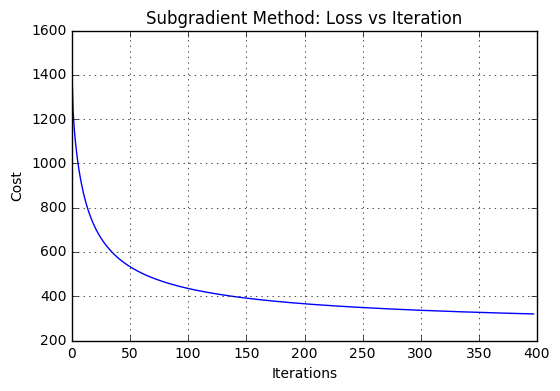

In [106]:
plt.plot(cost_total_subg)
plt.title('Subgradient Method: Loss vs Iteration')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

In [22]:
# number of weight between -10^(-3) and 10^(-3)
np.sum((best_w < 0.001)*1*((best_w > -0.001)*1))

77

In [ ]:
# ISTA

In [100]:
# tau function
def tau(alpha, weight):
    k=np.shape(weight)[0]
    j= np.multiply(np.maximum(np.absolute(weight.reshape(k,1)) - alpha, np.zeros((k,1))),np.sign(weight.reshape(k,1)))
    return j.reshape(k,1)

In [101]:
# calculate optimal step size for ISTA FISTA
eval_max = np.linalg.svd(np.dot(m.T,m))[1][1]
step_size = 1/(4*eval_max)

In [102]:
cost_ISTA = []
lamb = 0.05
t = step_size
cost=list()
w = np.zeros((x.shape[1],1))
for i in range(10000):
    s = 1/(1+np.exp(-np.dot(m,w)))
    s[s==1]=0.99999
    s[s==0]=0.00001
    n = w + t*np.dot(np.transpose(m),(y.reshape(-1,1)-s))
    w = tau(lamb*t,n)
    current_cost = -np.dot(y,np.log(s))-np.dot((1-y),np.log(1-s))+lamb*np.linalg.norm(w,ord = 1)
    cost_ISTA.append(current_cost)
    
    # stop if reach 320
    if current_cost <= 320:
        num_iteration_ISTA = i+1
        break

In [103]:
# number of iteration it takes to reach cost function <= 320
num_iteration_ISTA

5783

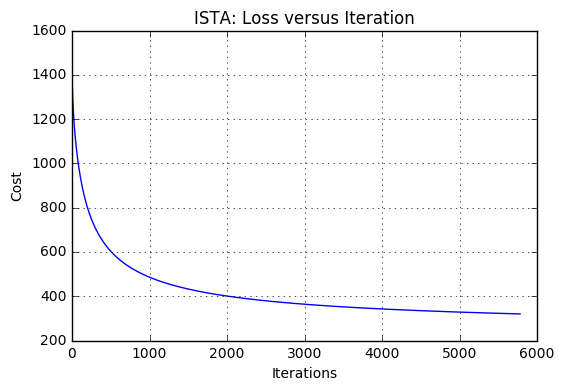

In [107]:
plt.plot(cost_ISTA)
#plt.legend(['SubGradient Descent','ISTA '],loc = 'upper right')
plt.title('ISTA: Loss versus Iteration')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

In [ ]:
# subgradient with decaying learning rate is slow (e.g: 0.05 lambda/k)
# here we are not considering the decaying learning rate
# ISTA fixed step size

In [ ]:
# ======================= FISTA ===============

In [30]:
def PL(x, lamb, t):
    s = 1/(1+np.exp(-np.dot(m,x)))
    s[s==1]=0.99999999999
    s[s==0]=0.00000000001
    x_fn = x + t*np.dot(np.transpose(m),(y.reshape(-1,1)-s))
    return tau(lamb*t,x_fn)

In [105]:
step_size

0.0034300241662903815

In [31]:
# FISTA
cost_FISTA = []
lamb = 0.05
t = step_size
w = np.zeros((x.shape[1],1))
v = w
for i in range(700):
    
    s = 1/(1+np.exp(-np.dot(m,w)))
    s[s==1]=0.9999
    s[s==0]=0.0001
    
    # update w, t, v
    w_old = np.copy(w)
    w = PL(v, lamb, t)
    t_old = np.copy(t)
    t = ((1+4*(t**2))**0.5+1)/2
    v = w + ((t_old-1)/t)*(w - w_old)
    
    # calculate cost
    current_cost = -np.dot(y,np.log(s))-np.dot((1-y),np.log(1-s))+lamb*np.linalg.norm(w,ord=1)
    #print(current_cost)
    cost_FISTA.append(current_cost)
    
    if current_cost < 320:
        num_iteration_FISTA = i+1
        break

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [32]:
# number of iteration it takes to reach cost function <= 320
num_iteration_FISTA

23

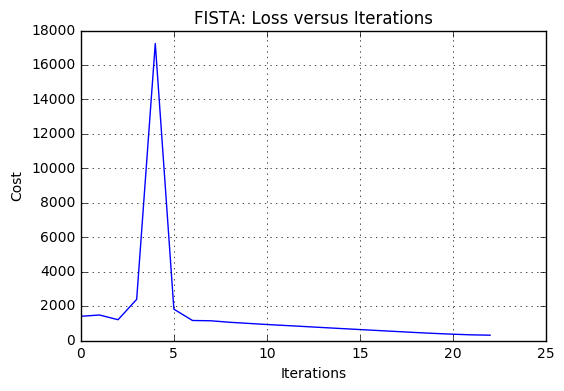

In [108]:
plt.plot(cost_FISTA)
plt.title('FISTA: Loss versus Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()

In [40]:
# ======== Comparison =============
itr = [num_iteration_sub, num_iteration_ISTA, num_iteration_FISTA]

In [41]:
itr

[398, 5783, 23]